# Tardis data analyse

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
from difflib import get_close_matches

In [2]:
df = pd.read_csv("./dataset.csv", sep=";")
df.head()

,Date,Service,Departure station,Arrival station,Average journey time,Number of scheduled trains,Number of cancelled trains,Cancellation comments,Number of trains delayed at departure,Average delay of late trains at departure,...,Number of trains delayed > 15min,Average delay of trains > 15min (if competing with flights),Number of trains delayed > 30min,Number of trains delayed > 60min,Pct delay due to external causes,Pct delay due to infrastructure,Pct delay due to traffic management,Pct delay due to rolling stock,Pct delay due to station management and equipment reuse,"Pct delay due to passenger handling (crowding, disabled persons, connections)"
0,2018-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141.0,NaN,5.0,NaN,289.0,11.247809,...,110.0,346.474287,44.0,8.0,36.134454,31.092437,10.924370,15.966387,5.042017,75.91573
1,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165.0,222.0,NaN,NaN,8.0,2.875000,...,22.0,5.696096,5.0,NaN,15.384615,30.769231,38.461538,11.538462,3.846154,0.00000
2,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220.0,248.0,1.0,NaN,37.0,9.501351,...,26.0,7.548387,17.0,7.0,26.923077,38.461538,NaN,19.230769,0.000000,0.00000
3,2018j01,National,PARIS MONTPARNASSE,ST MALO,156.0,102.0,0.0,NaN,12.0,19.912500,...,8.0,6.724757,6.0,4.0,23.076923,218.650888,7.692308,15.384615,7.692308,NaN
4,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61.0,391.0,2.0,NaN,61.0,NaN,...,17.0,3.346487,6.0,0.0,21.212121,42.424242,9.090909,21.212121,6.060606,0.00000


## Clean the duplicates strings in the data
    Print duplicates and clean them

In [3]:
df = pd.DataFrame(df)
len(df)

10840

In [4]:
duplicates = df.duplicated(keep="first").sum()
print(f"Number of duplicate entries: {duplicates}")
df_cleaned = df.drop_duplicates()

Number of duplicate entries: 178


In [5]:
len(df_cleaned)

10662

## Management of the missing values

In [6]:
missing_values = df_cleaned.isnull().sum()
print(missing_values)

Date                                                                               534
Service                                                                            533
Departure station                                                                  531
Arrival station                                                                    536
Average journey time                                                               820
Number of scheduled trains                                                         809
Number of cancelled trains                                                         818
Cancellation comments                                                            10662
Number of trains delayed at departure                                              816
Average delay of late trains at departure                                          802
Average delay of all trains at departure                                           812
Departure delay comments                   

Dropping useless columns

In [7]:
df = df_cleaned.drop(columns="Cancellation comments")
df = df.drop(columns="Departure delay comments")
df = df.drop(columns="Arrival delay comments")

Clean Time

Put the date at the right format

In [8]:
df["Date"] = df["Date"].str.replace(r"[^0-9]", "", regex="True")
df["Date"] = df["Date"].apply(lambda x: str(x))

In [9]:
def right_format(s):
    s = s.zfill(6)
    year = s[:4]
    month = s[4:6]
    return f"{year}-{month}"


df["Date"] = df["Date"].apply(right_format)

In [10]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m", errors="coerce")
df["Date"] = df["Date"].dt.strftime("%Y-%m")

ADD missing time value

In [11]:
df = df.reset_index(drop=True)
df["Date"] = df["Date"].ffill()
df["Date"] = df["Date"].bfill()

In [12]:
missing_values = df.isnull().sum()
print(missing_values)

Date                                                                               0
Service                                                                          533
Departure station                                                                531
Arrival station                                                                  536
Average journey time                                                             820
Number of scheduled trains                                                       809
Number of cancelled trains                                                       818
Number of trains delayed at departure                                            816
Average delay of late trains at departure                                        802
Average delay of all trains at departure                                         812
Number of trains delayed at arrival                                              815
Average delay of late trains at arrival                          

# Clean the stations columns
Verify if there are missing value

In [13]:
missing_depart = df["Departure station"].isna()
missing_arrival = df["Arrival station"].isna()
missing_both = missing_depart & missing_arrival
missing_both.sum()

np.int64(33)

In [14]:
df_cleaned = df[~missing_both]

In [15]:
missing_values = df_cleaned.isnull().sum()
print(missing_values)
len(df_cleaned)
df = df_cleaned

Date                                                                               0
Service                                                                          533
Departure station                                                                498
Arrival station                                                                  503
Average journey time                                                             819
Number of scheduled trains                                                       804
Number of cancelled trains                                                       814
Number of trains delayed at departure                                            811
Average delay of late trains at departure                                        801
Average delay of all trains at departure                                         808
Number of trains delayed at arrival                                              811
Average delay of late trains at arrival                          

Clean the stations names to make sure its at the right format

In [16]:
valid_stations = pd.read_csv("./datas/liste-des-gares.csv")
reference_stations = valid_stations["LIBELLE"].tolist()

unique_departure = df["Departure station"].dropna().unique()
unique_arrival = df["Arrival station"].dropna().unique()
all_unique_stations = np.union1d(unique_departure, unique_arrival)

In [17]:
def similarity_score(a, b):
    return SequenceMatcher(None, a.lower(), b.lower()).ratio() * 100

def get_best_match(station_name):
    if pd.isna(station_name):
        return station_name

    station_upper = str(station_name).upper()
    exact_matches = [s for s in reference_stations if s.upper() == station_upper]
    if exact_matches:
        return exact_matches[0]
    if " " not in station_upper:
        city_name = station_upper
        similar_cities = []
        for ref_station in reference_stations:
            ref_city = ref_station.split(" ")[0]
            similarity = similarity_score(city_name, ref_city)
            if similarity > 65:
                similar_cities.append((ref_station, similarity))
        if similar_cities:
            similar_cities.sort(key=lambda x: x[1], reverse=True)
            return similar_cities[0][0]
    close_matches = get_close_matches(station_upper, [s.upper() for s in reference_stations], n=1, cutoff=0.7)
    if close_matches:
        for s in reference_stations:
            if s.upper() == close_matches[0]:
                return s

station_mapping = {}

In [18]:
for station in all_unique_stations:
    if pd.notna(station):
        station_mapping[station] = get_best_match(station)
df["Departure station"] = df["Departure station"].map(
    lambda x: station_mapping.get(x, x)
)
df["Arrival station"] = df["Arrival station"].map(lambda x: station_mapping.get(x, x))

## Define services

In [19]:
print("Unique values in Service column before cleaning:")
print(df["Service"].unique())

Unique values in Service column before cleaning:
['National' nan 'NatioGal' 'International' 'uational' 'InternatNonal'
 'NatioAal' 'Natiobal' 'InternatConal' 'NatioVal' 'NaRional' 'Nattonal'
 'gational' 'Natioial' '3ational' 'fational' 'NatiMnal' 'InternationaB'
 'InternatFonal' 'Nationav' 'NGtional' 'InternatAonal' 'InternatioYal'
 'Nationa6' 'Nation8l' 'InternatioAal' 'Nationa9' 'Natignal' 'Napional'
 'Natfonal' 'NaWional' 'rational' 'Inteenational' 'Nktional' 'Nationaj'
 'Nationao' 'Natinnal' 'Nationtl' 'NatioMal' 'NatioCal' 'Nationag'
 'Nataonal' 'NationaB' 'NatTonal' 'Natiznal' 'Nationa1' 'Nationzl'
 'Nationab' 'NatiJnal' 'Internajional' 'NMtional' 'NatiHnal' 'Nati7nal'
 'Nafional' 'InternaRional' 'Na4ional' 'InSernational' 'Nagional'
 'pational' 'Natio2al' 'NationPl' 'Natiopal' 'Natconal' 'NaCional'
 'Eational' 'NatiWnal' 'Nationml' 'NationaP' 'NFtional' 'Nationae'
 'Natixnal' 'NaAional' '9ational' 'NationaM' 'NationAl' 'NaHional'
 'Inxernational' 'xational' 'NatiRnal' 'NAtional'

In [20]:
def standardize_service(value):
    if pd.isna(value):
        return value
    value = str(value).strip()
    national_score = similarity_score(value, "national")
    international_score = similarity_score(value, "international")
    if national_score > 60 and national_score > international_score:
        return "National"
    elif international_score > 60 and international_score > national_score:
        return "International"
    return value

In [21]:
df["Service"] = df["Service"].apply(standardize_service)

for idx, row in df[df["Service"].isna()].iterrows():
    depart = (
        str(row["Departure station"]).upper()
        if pd.notna(row["Departure station"])
        else ""
    )
    arrive = (
        str(row["Arrival station"]).upper() if pd.notna(row["Arrival station"]) else ""
    )

    international_keywords = [
        "BARCELONA",
        "GENEVE",
        "MADRID",
        "FRANCFORT",
        "ZURICH",
        "ITALIE",
        "STUTTGART",
        "LAUSANNE",
    ]
    is_international = any(
        keyword in depart or keyword in arrive for keyword in international_keywords
    )

    df.at[idx, "Service"] = "International" if is_international else "National"

In [22]:
print("\nUnique values in Service column after cleaning:")
print(df["Service"].unique())
print(f"Missing values: {df['Service'].isna().sum()}")


Unique values in Service column after cleaning:
['National' 'International']
Missing values: 0


In [23]:
df.fillna("")
df.isna().sum()
df.reset_index()

,index,Date,Service,Departure station,Arrival station,Average journey time,Number of scheduled trains,Number of cancelled trains,Number of trains delayed at departure,Average delay of late trains at departure,...,Number of trains delayed > 15min,Average delay of trains > 15min (if competing with flights),Number of trains delayed > 30min,Number of trains delayed > 60min,Pct delay due to external causes,Pct delay due to infrastructure,Pct delay due to traffic management,Pct delay due to rolling stock,Pct delay due to station management and equipment reuse,"Pct delay due to passenger handling (crowding, disabled persons, connections)"
0,0,2018-01,National,Bordeaux-St-Jean,Paris-Montparnasse,141.000000,NaN,5.0,289.0,11.247809,...,110.0,346.474287,44.0,8.0,36.134454,31.092437,10.924370,15.966387,5.042017,75.915730
1,1,2018-01,National,La Rochelle-Ville,Paris-Montparnasse,165.000000,222.000000,NaN,8.0,2.875000,...,22.0,5.696096,5.0,NaN,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,2,2018-01,National,Paris-Montparnasse,Quimper,220.000000,248.000000,1.0,37.0,9.501351,...,26.0,7.548387,17.0,7.0,26.923077,38.461538,NaN,19.230769,0.000000,0.000000
3,3,2018-01,National,Paris-Montparnasse,St-Malo,156.000000,102.000000,0.0,12.0,19.912500,...,8.0,6.724757,6.0,4.0,23.076923,218.650888,7.692308,15.384615,7.692308,NaN
4,4,2018-01,National,Paris-Montparnasse,St-Pierre-des-Corps,61.000000,391.000000,2.0,61.0,NaN,...,17.0,3.346487,6.0,0.0,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10624,10657,2020-04,National,None,Strasbourg-Ville,NaN,40.000000,35.0,5.0,1.253333,...,3.0,NaN,3.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
10625,10658,2020-05,National,NaN,Lyon-Part-Dieu,115.000000,2681.206158,14.0,46.0,6.258333,...,5.0,47.820000,3.0,1.0,0.000000,50.000000,0.000000,0.000000,50.000000,0.000000
10626,10659,2021-03,National,None,None,130.000000,178.000000,10.0,5.0,2.946667,...,4.0,66.254167,4.0,2.0,25.000000,25.000000,198.761036,25.000000,0.000000,25.000000
10627,10660,2019-07,National,Marne-la-Vallée-Chessy,Marseille-St-Charles,217.000000,268.000000,NaN,238.0,10.391667,...,66.0,50.361364,34.0,22.0,24.615385,15.384615,15.384615,24.615385,10.769231,9.230769


## Transform average time into hour times

In [24]:
def minutes_to_hour(minutes):
    if pd.isna(minutes):
        return None
    try:
        mins = int(minutes)
        hours = mins // 60
        remaining_mins = mins % 60
        return f"{hours:02d}:{remaining_mins:02d}"
    except ValueError:
        return None


In [25]:
df["Average delay late departure in Hour"] = df[
    "Average delay of late trains at departure"
].apply(minutes_to_hour)

In [26]:
df["Average delay departure in Hour"] = df[
    "Average delay of all trains at departure"
].apply(minutes_to_hour)

# Export to csv

In [27]:
df.to_csv("cleaned_dataset.csv")

## Visualisation of the dataset

In [28]:
data = pd.read_csv("cleaned_dataset.csv")
data = data.sample(100)

# Load the cleaned dataset


In [29]:
df = pd.read_csv("cleaned_dataset.csv")

# Basic summary statistics

In [30]:
print("Dataset shape:", df.shape)
print("\nSummary statistics for delay metrics:")
delay_columns = [col for col in df.columns if "delay" in col.lower()]
print(df[delay_columns].describe())

Dataset shape: (10629, 26)

Summary statistics for delay metrics:
       Number of trains delayed at departure  \
count                            9818.000000   
mean                              128.193201   
std                               196.031773   
min                                 0.000000   
25%                                23.000000   
50%                                58.000000   
75%                               145.000000   
max                               872.292007   

       Average delay of late trains at departure  \
count                                9828.000000   
mean                                   17.359189   
std                                    26.274418   
min                                     0.000000   
25%                                     6.019308   
50%                                    10.309091   
75%                                    16.455076   
max                                   270.438095   

       Average delay of all trai

# Convert time columns to proper datetime format

In [31]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m")

# Function to convert time strings to minutes for analysis

In [32]:
def hour_to_minutes(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        hours, minutes = map(int, time_str.split(":"))
        return hours * 60 + minutes
    except (ValueError, AttributeError):
        return np.nan

# Convert hour format delays back to minutes for analysis

In [33]:
df["Delay_Departure_Minutes"] = df["Average delay late departure in Hour"].apply(
    hour_to_minutes
)
df["All_Trains_Delay_Minutes"] = df["Average delay departure in Hour"].apply(
    hour_to_minutes
)

# Distribution of delays for late trains

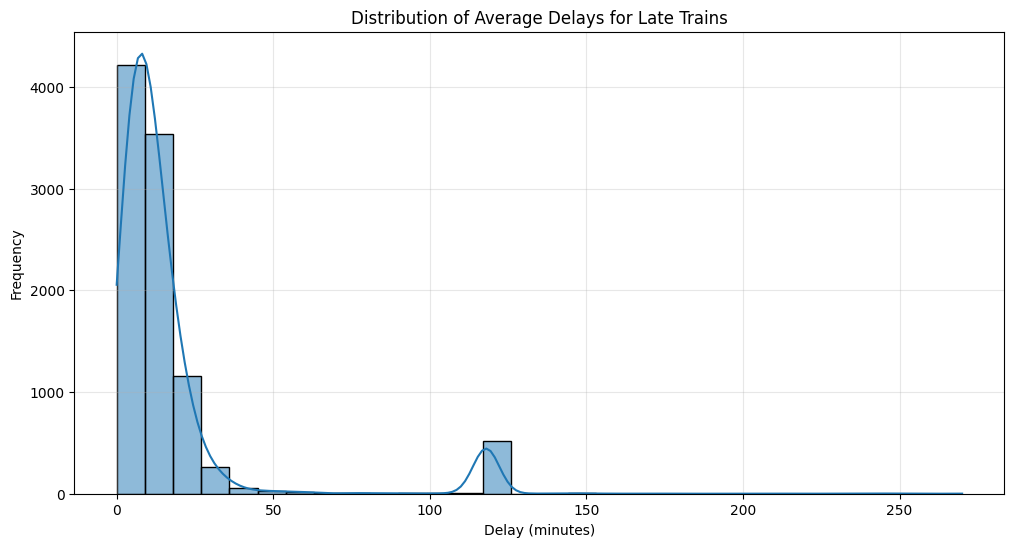

In [34]:
plt.figure(figsize=(12, 6))
sns.histplot(df["Delay_Departure_Minutes"].dropna(), kde=True, bins=30)
plt.title("Distribution of Average Delays for Late Trains")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

# Compare delays between National and International services

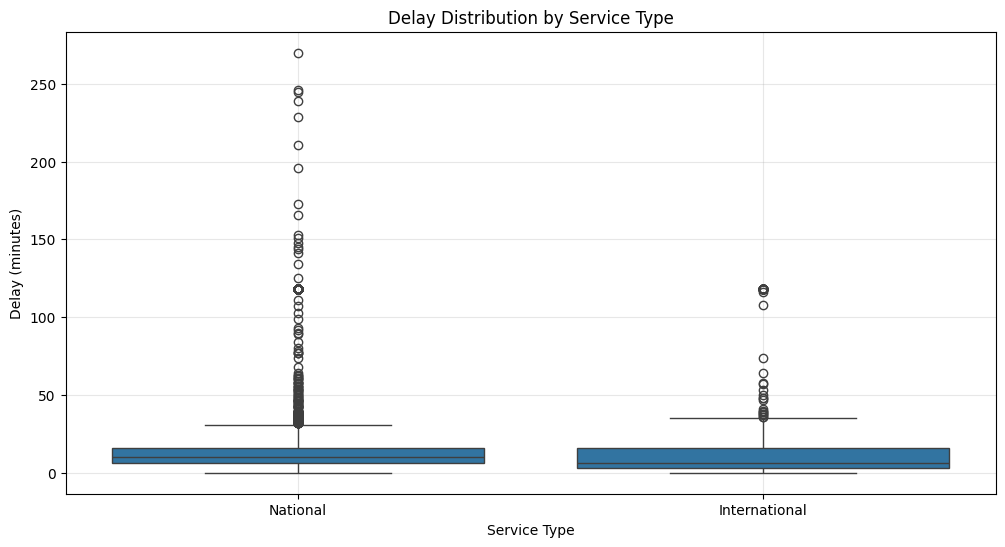

In [35]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Service", y="Delay_Departure_Minutes", data=df)
plt.title("Delay Distribution by Service Type")
plt.xlabel("Service Type")
plt.ylabel("Delay (minutes)")
plt.grid(True, alpha=0.3)
plt.show()

# Top 10 stations with highest average delays

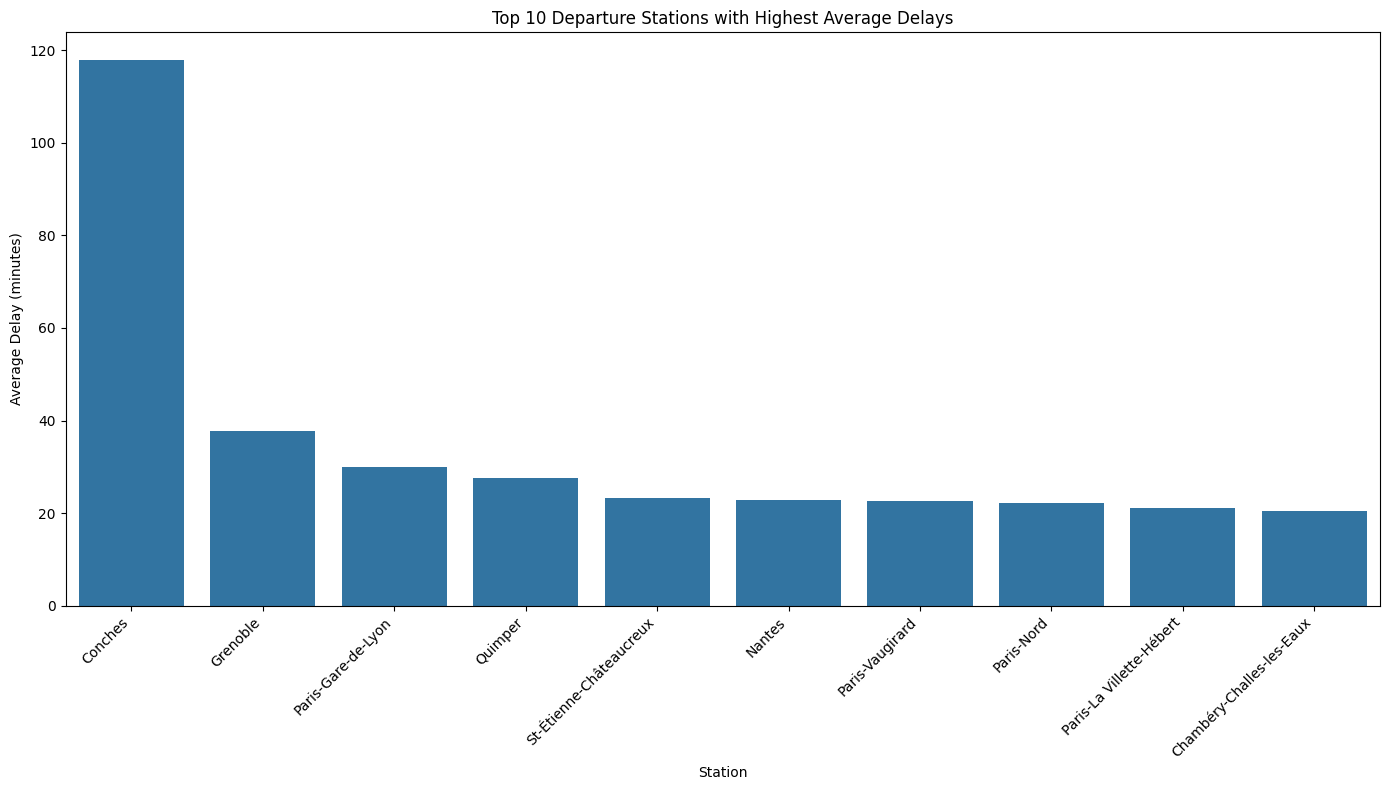

In [36]:
top_stations = (
    df.groupby("Departure station")["Delay_Departure_Minutes"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
plt.figure(figsize=(14, 8))
sns.barplot(x=top_stations.index, y=top_stations.values)
plt.title("Top 10 Departure Stations with Highest Average Delays")
plt.xlabel("Station")
plt.ylabel("Average Delay (minutes)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Delay trends over time

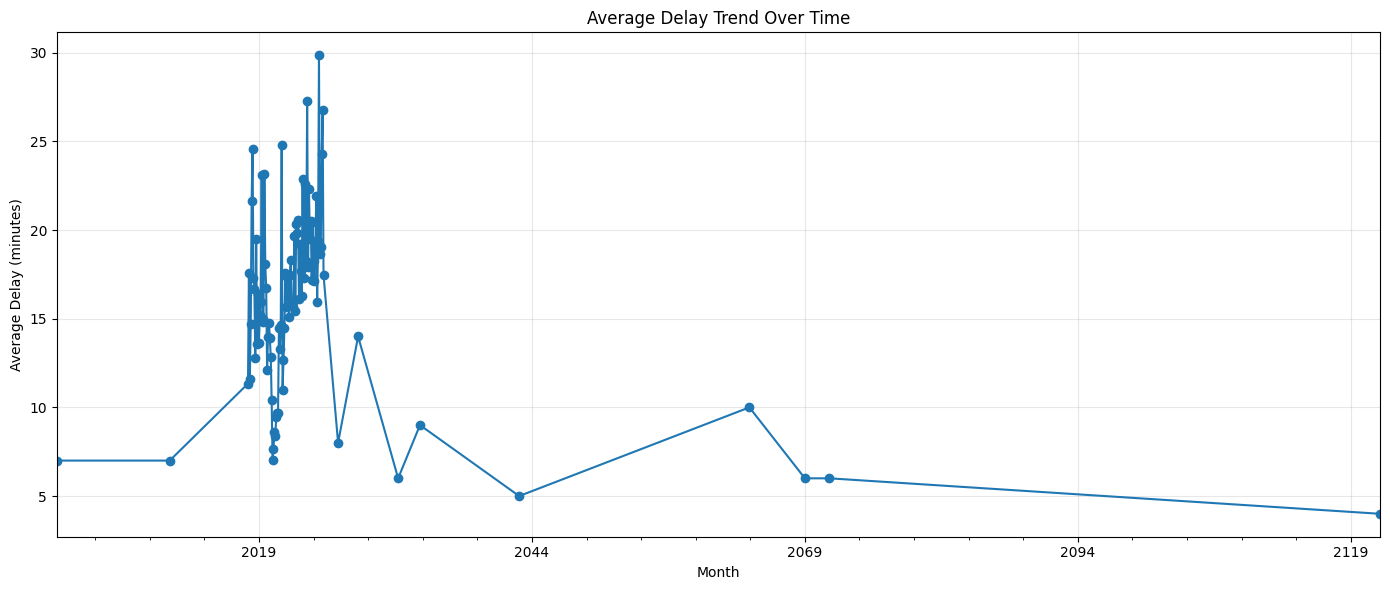

In [37]:
monthly_delays = df.groupby(df["Date"].dt.to_period("M"))[
    "Delay_Departure_Minutes"
].mean()
plt.figure(figsize=(14, 6))
monthly_delays.plot(kind="line", marker="o")
plt.title("Average Delay Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Average Delay (minutes)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Heatmap of correlations between variables

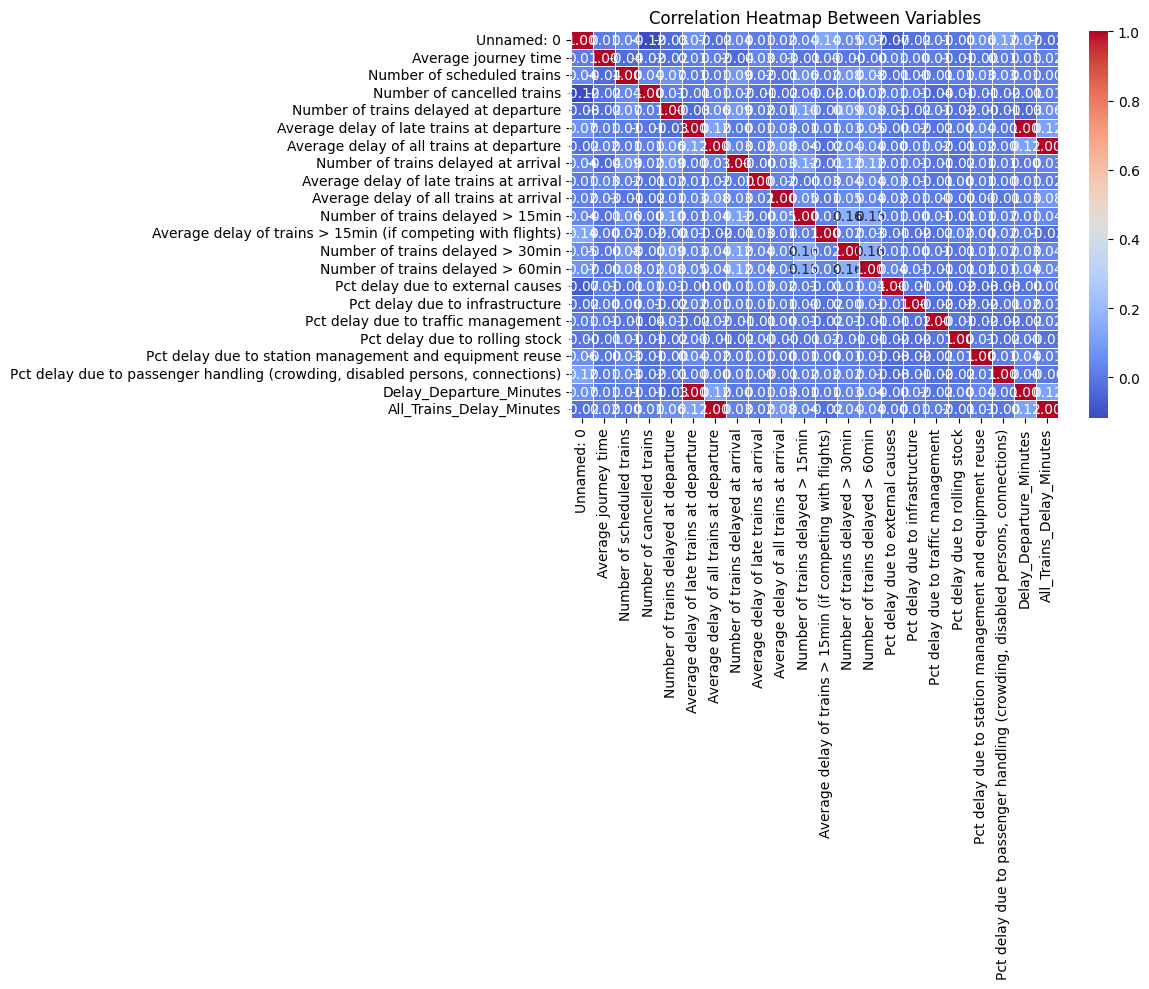

In [38]:
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap Between Variables")
plt.tight_layout()
plt.show()

# Delay comparison between departure and arrival

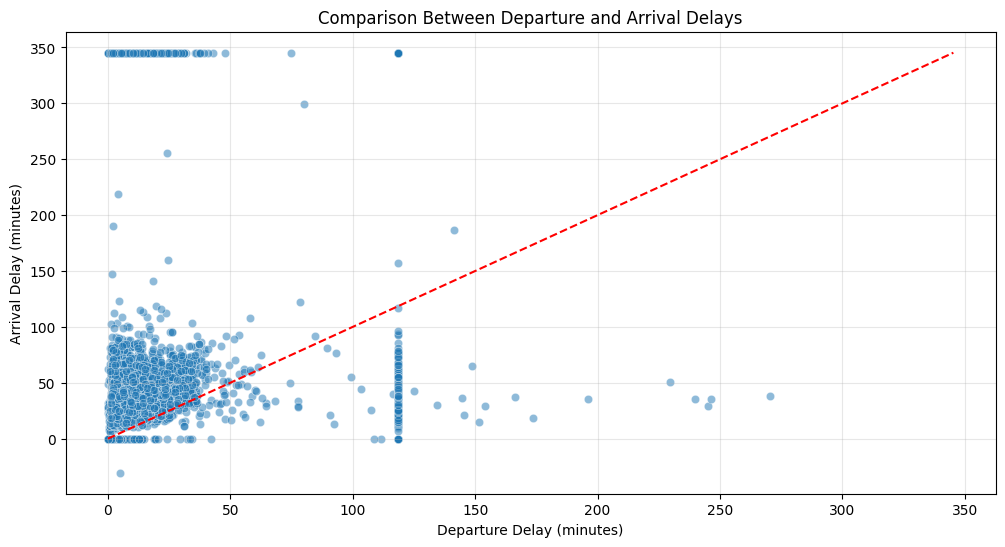

In [39]:
plt.figure(figsize=(12, 6))
df_subset = df[
    [
        "Average delay of late trains at departure",
        "Average delay of late trains at arrival",
    ]
].dropna()
sns.scatterplot(
    x="Average delay of late trains at departure",
    y="Average delay of late trains at arrival",
    data=df_subset,
    alpha=0.5,
)
plt.title("Comparison Between Departure and Arrival Delays")
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Arrival Delay (minutes)")
plt.grid(True, alpha=0.3)
max_val = max(df_subset.max())
plt.plot([0, max_val], [0, max_val], "r--")
plt.show()

# Delay distribution by month

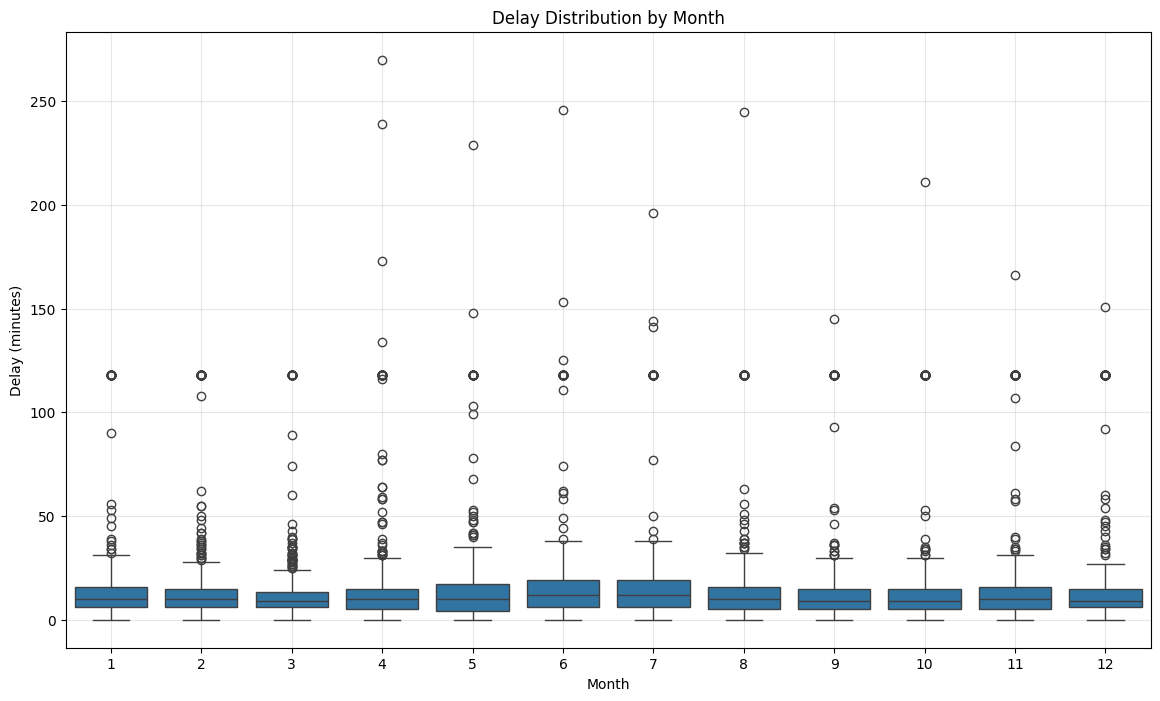

In [40]:
plt.figure(figsize=(14, 8))
df["Month"] = df["Date"].dt.month
sns.boxplot(x="Month", y="Delay_Departure_Minutes", data=df)
plt.title("Delay Distribution by Month")
plt.xlabel("Month")
plt.ylabel("Delay (minutes)")
plt.grid(True, alpha=0.3)
plt.show()

# Delay heatmap by departure and arrival stations

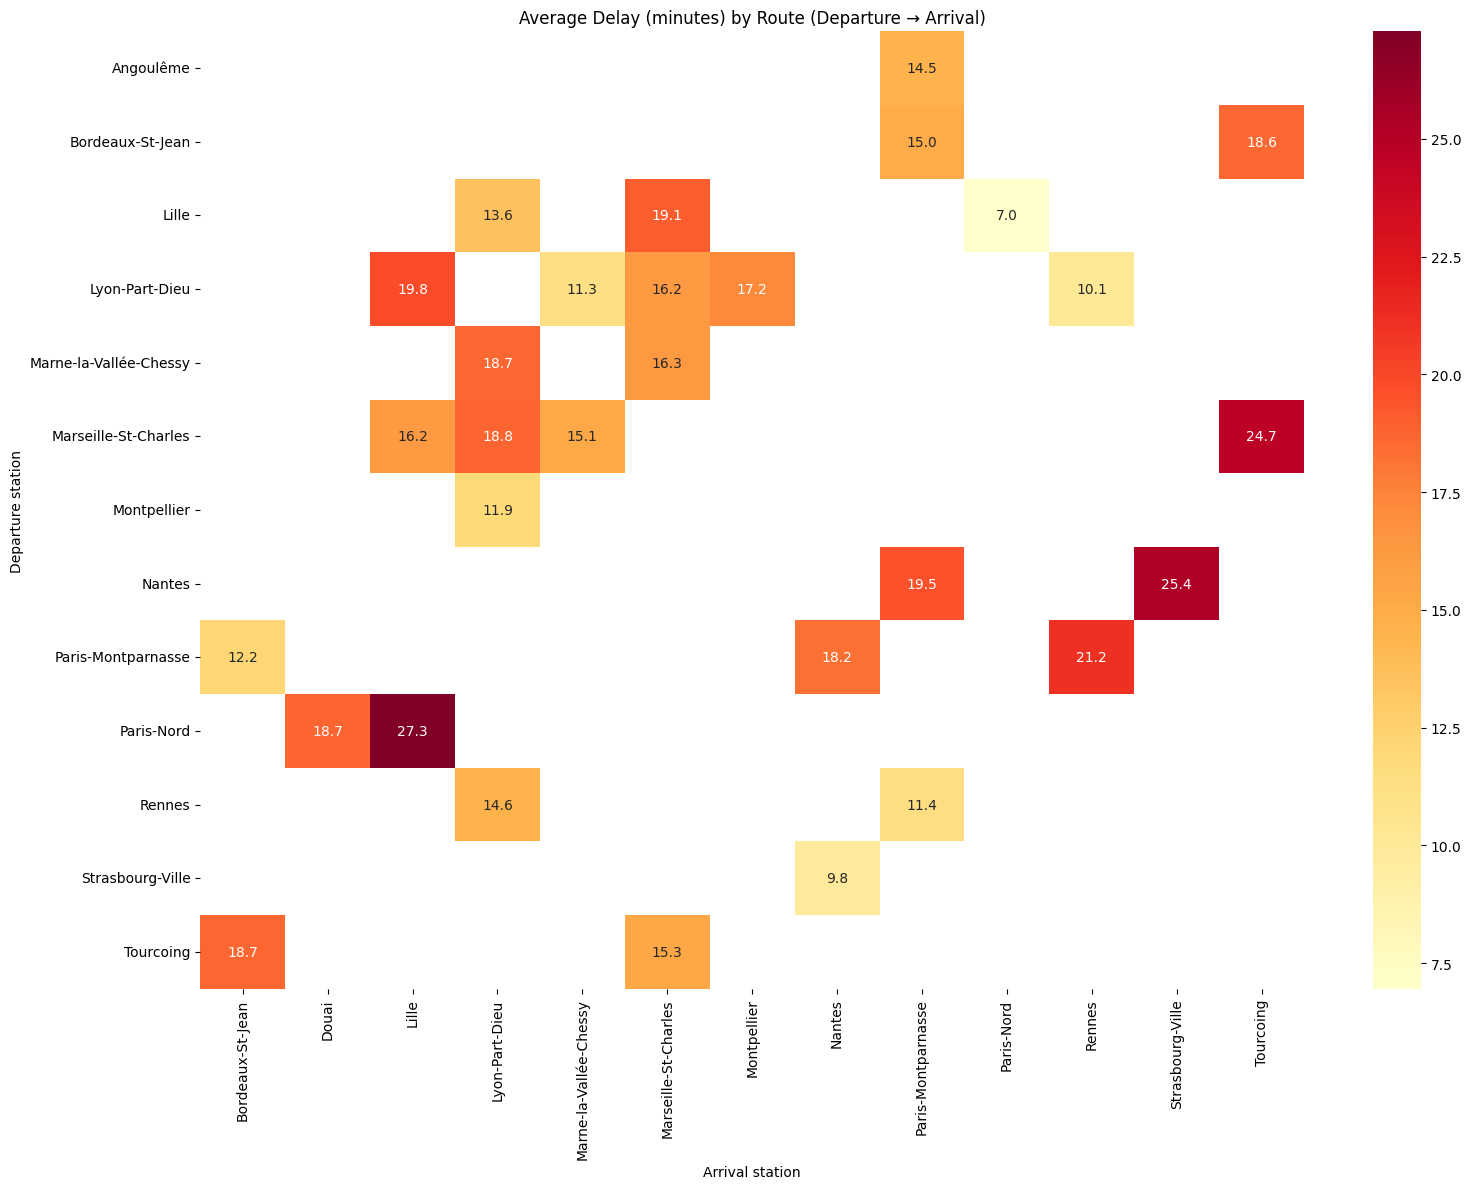

In [41]:
top_departure = df["Departure station"].value_counts().head(15).index
top_arrival = df["Arrival station"].value_counts().head(15).index
filtered_df = df[
    df["Departure station"].isin(top_departure)
    & df["Arrival station"].isin(top_arrival)
]
pivot_data = filtered_df.pivot_table(
    values="Delay_Departure_Minutes",
    index="Departure station",
    columns="Arrival station",
    aggfunc="mean",
)
plt.figure(figsize=(16, 12))
sns.heatmap(pivot_data, annot=True, cmap="YlOrRd", fmt=".1f")
plt.title("Average Delay (minutes) by Route (Departure → Arrival)")
plt.tight_layout()
plt.show()